In [ ]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

plt.style.use('seaborn')

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
# Downloading and Loading Dataset
transform = transforms.Compose([
    # transforms.Grayscale(),
    transforms.ToTensor()
])
train_dataset = datasets.SVHN(root='drive/MyDrive/data/lab3', split='train', transform=transform, download=True)
 
test_dataset = datasets.SVHN(root='drive/MyDrive/data/lab3', split='test', transform=transform, download=True)

Using downloaded and verified file: drive/MyDrive/data/lab3/train_32x32.mat
Using downloaded and verified file: drive/MyDrive/data/lab3/test_32x32.mat


In [ ]:
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE, 
                                          shuffle=False)

In [ ]:
class CNN(nn.Module):
    """ 
    Varation of LeNet: a simple CNN model
    for handwritten digit recognition
    """
    def __init__(self, downsample_method='dilated', dilated_kernel_size=5, dropout=False):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (1, 28, 28)
        conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # (16, 24, 24)
        relu1 = nn.ReLU()

        if downsample_method == 'max':
            downsample1 = nn.MaxPool2d(kernel_size=2)
        elif downsample_method == 'avg':
            downsample1 = nn.AvgPool2d(kernel_size=2)
        elif downsample_method == 'dilated':
            downsample1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=dilated_kernel_size, stride=2)
        # (16, 12, 12)
        if dropout:
            self.layer1 = nn.Sequential(conv1, relu1, nn.Dropout(), downsample1)
        else:
            self.layer1 = nn.Sequential(conv1, relu1, downsample1)
      
        # layer 2
        # (16, 12, 12)
        conv2 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=5, stride=1, padding=0)
        # (32, 8, 8)
        relu2 = nn.ReLU()
        if downsample_method == 'max':
            downsample2 = nn.MaxPool2d(kernel_size=2)
        elif downsample_method == 'avg':
            downsample2 = nn.AvgPool2d(kernel_size=2)
        elif downsample_method == 'dilated':
            downsample2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=dilated_kernel_size, stride=2)
        # (32, 4, 4)
        if dropout:
            self.layer2 = nn.Sequential(conv2, relu2, nn.Dropout(), downsample2)
        else:
            self.layer2 = nn.Sequential(conv2, relu2, downsample2)
        
        # fully connected classifier
        if downsample_method == 'dilated':
            in_dim = 128
        else:
            in_dim = 800
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1) # (B, 32, 4 ,4 ) -> (B, 32 * 4 * 4)
        out2_flat = out2.view(b_size, -1)
        y = self.fc(out2_flat)
        return y

In [ ]:
class Trainer:
    def __init__(self, model, savepath, save_freq=10, eval_freq=1):
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.eval_freq = eval_freq
        self.save_freq = save_freq
        self.stats = {
            "epoch": [],
            "train_loss": [],
            "valid_loss": [],
            "accuracy": []
        }
        self.savepath = savepath

    @torch.no_grad()
    def eval_model(self, test_loader):
        """ Computing model accuracy """
        correct = 0
        total = 0
        loss_list = []
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass only to get logits/output
            outputs = self.model(images)
                    
            loss = self.criterion(outputs, labels)
            loss_list.append(loss.item())
                
            # Get predictions from the maximum value
            preds = torch.argmax(outputs, dim=1)
            correct += len( torch.where(preds==labels)[0] )
            total += len(labels)
                    
        # Total correct predictions and loss
        accuracy = correct / total * 100
        loss = np.mean(loss_list)
        return accuracy, loss
    
    def save_model(self, optimizer, epoch):
        """ Saving model checkpoint """

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': self.stats
        }, f'{self.savepath}/chckpt_{epoch}.pth')
        
        return

    def load_model(self, optimizer, savepath):
        """ Loading pretrained checkpoint """
        
        checkpoint = torch.load(savepath)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint["epoch"]
        stats = checkpoint["stats"]
        
        return self.model, optimizer, epoch, stats

    def train(self, train_loader, test_loader, num_epochs, lr, device, optimizer, init_epoch=0, valid_loss_diff_to_stop=0.003):
        self.model.train()
        self.model.to(device)
        self.criterion.to(device)
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        loss_hist = []

        for epoch in range(init_epoch, num_epochs):
            # EARLY STOPPING
            if len(self.stats['valid_loss']) >= 2:
                if self.stats['valid_loss'][-2] - self.stats['valid_loss'][-1] < valid_loss_diff_to_stop:
                    print('Early stopping criterion is met')
                    break

            loss_list = []
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
            for i, (images, labels) in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
                
                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()
                
                # Forward pass to get output/logits
                outputs = self.model(images)
                
                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(outputs, labels)
                loss_list.append(loss.item())
                
                # Getting gradients w.r.t. parameters
                loss.backward()
                
                # Updating parameters
                optimizer.step()
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

            loss_hist.append(np.mean(loss_list))
            self.stats["epoch"].append(epoch)
            self.stats["train_loss"].append(loss_hist[-1])
            
            # evaluating model
            if epoch % self.eval_freq == 0:
                accuracy, valid_loss = self.eval_model(test_loader)  
                print(f"Validation accuracy at epoch {epoch}: {round(accuracy, 2)}%")
                print(f"Validation loss at epoch {epoch}: {round(valid_loss, 5)}")
            else:   
                accuracy, valid_loss = -1, -1
            self.stats["accuracy"].append(accuracy)
            self.stats["valid_loss"].append(valid_loss)
            
            # saving checkpoint
            if epoch % self.save_freq == 0:
                self.save_model(optimizer=optimizer, epoch=epoch)


In [ ]:
cnn_max = CNN(downsample_method='max')
cnn_avg = CNN(downsample_method='avg')
cnn_dilated = CNN(downsample_method='dilated')

if(not os.path.exists("drive/MyDrive/models/max")):
    os.makedirs("drive/MyDrive/models/max")
if(not os.path.exists("drive/MyDrive/models/avg")):
    os.makedirs("drive/MyDrive/models/avg")
if(not os.path.exists("drive/MyDrive/models/dilated")):
    os.makedirs("drive/MyDrive/models/dilated")
if(not os.path.exists("drive/MyDrive/models/max_dropout")):
    os.makedirs("drive/MyDrive/models/max_dropout")

cnn_max_trainer = Trainer(cnn_max, savepath='drive/MyDrive/models/max')
cnn_avg_trainer = Trainer(cnn_avg, savepath='drive/MyDrive/models/avg')
cnn_dilated_trainer = Trainer(cnn_dilated, savepath='drive/MyDrive/models/dilated')

In [ ]:
cnn_dilated_dropout = CNN(downsample_method='dilated', dropout=True)
if(not os.path.exists("drive/MyDrive/models/dilated_dropout")):
    os.makedirs("drive/MyDrive/models/dilated_dropout")
cnn_dilated_dropout_trainer = Trainer(cnn_dilated_dropout, savepath='drive/MyDrive/models/max_dropout')

In [ ]:
lr = 3e-4
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cnn_dilated_optimizer = torch.optim.Adam(params=cnn_dilated.parameters(), lr=lr)
%time cnn_dilated_trainer.train(train_loader, test_loader, num_epochs, lr, device, cnn_dilated_optimizer)

Epoch 1 Iter 287: loss 0.72595. : 100%|██████████| 287/287 [00:13<00:00, 21.00it/s]


Validation accuracy at epoch 0: 67.23%
Validation loss at epoch 0: 1.10573


Epoch 2 Iter 287: loss 0.82991. : 100%|██████████| 287/287 [00:13<00:00, 21.99it/s]


Validation accuracy at epoch 1: 76.55%
Validation loss at epoch 1: 0.83711


Epoch 3 Iter 287: loss 0.41479. : 100%|██████████| 287/287 [00:12<00:00, 22.49it/s]


Validation accuracy at epoch 2: 79.54%
Validation loss at epoch 2: 0.74228


Epoch 4 Iter 287: loss 0.55088. : 100%|██████████| 287/287 [00:12<00:00, 22.70it/s]


Validation accuracy at epoch 3: 81.87%
Validation loss at epoch 3: 0.6694


Epoch 5 Iter 287: loss 0.80175. : 100%|██████████| 287/287 [00:13<00:00, 21.39it/s]


Validation accuracy at epoch 4: 82.72%
Validation loss at epoch 4: 0.63425


Epoch 6 Iter 287: loss 0.40417. : 100%|██████████| 287/287 [00:12<00:00, 22.54it/s]


Validation accuracy at epoch 5: 83.95%
Validation loss at epoch 5: 0.59264


Epoch 7 Iter 287: loss 0.50538. : 100%|██████████| 287/287 [00:12<00:00, 22.63it/s]


Validation accuracy at epoch 6: 84.32%
Validation loss at epoch 6: 0.57849


Epoch 8 Iter 287: loss 0.89076. : 100%|██████████| 287/287 [00:12<00:00, 22.45it/s]


Validation accuracy at epoch 7: 85.07%
Validation loss at epoch 7: 0.56054


Epoch 9 Iter 287: loss 0.51710. : 100%|██████████| 287/287 [00:12<00:00, 22.36it/s]


Validation accuracy at epoch 8: 85.32%
Validation loss at epoch 8: 0.54596


Epoch 10 Iter 287: loss 0.39306. : 100%|██████████| 287/287 [00:12<00:00, 22.60it/s]


Validation accuracy at epoch 9: 85.53%
Validation loss at epoch 9: 0.53586


Epoch 11 Iter 287: loss 0.47495. : 100%|██████████| 287/287 [00:12<00:00, 22.47it/s]


Validation accuracy at epoch 10: 85.83%
Validation loss at epoch 10: 0.53522
Early stopping criterion is met
CPU times: user 2min 55s, sys: 4.18 s, total: 2min 59s
Wall time: 3min 2s


In [ ]:
cnn_max_optimizer = torch.optim.Adam(params=cnn_max.parameters(), lr=lr)
%time cnn_max_trainer.train(train_loader, test_loader, num_epochs, lr, device, cnn_max_optimizer)

Epoch 1 Iter 287: loss 1.17232. : 100%|██████████| 287/287 [00:12<00:00, 23.78it/s]


Validation accuracy at epoch 0: 63.96%
Validation loss at epoch 0: 1.27416


Epoch 2 Iter 287: loss 0.89310. : 100%|██████████| 287/287 [00:12<00:00, 23.54it/s]


Validation accuracy at epoch 1: 76.04%
Validation loss at epoch 1: 0.86356


Epoch 3 Iter 287: loss 0.53957. : 100%|██████████| 287/287 [00:11<00:00, 23.99it/s]


Validation accuracy at epoch 2: 79.94%
Validation loss at epoch 2: 0.73682


Epoch 4 Iter 287: loss 0.59073. : 100%|██████████| 287/287 [00:12<00:00, 23.64it/s]


Validation accuracy at epoch 3: 81.88%
Validation loss at epoch 3: 0.67819


Epoch 5 Iter 287: loss 0.51334. : 100%|██████████| 287/287 [00:12<00:00, 23.79it/s]


Validation accuracy at epoch 4: 82.46%
Validation loss at epoch 4: 0.65276


Epoch 6 Iter 287: loss 0.39159. : 100%|██████████| 287/287 [00:12<00:00, 23.74it/s]


Validation accuracy at epoch 5: 82.84%
Validation loss at epoch 5: 0.6317


Epoch 7 Iter 287: loss 0.47961. : 100%|██████████| 287/287 [00:11<00:00, 23.97it/s]


Validation accuracy at epoch 6: 83.58%
Validation loss at epoch 6: 0.6139


Epoch 8 Iter 287: loss 0.35799. : 100%|██████████| 287/287 [00:12<00:00, 23.81it/s]


Validation accuracy at epoch 7: 84.06%
Validation loss at epoch 7: 0.60041


Epoch 9 Iter 287: loss 0.53183. : 100%|██████████| 287/287 [00:11<00:00, 24.08it/s]


Validation accuracy at epoch 8: 84.29%
Validation loss at epoch 8: 0.59444


Epoch 10 Iter 287: loss 0.44266. : 100%|██████████| 287/287 [00:11<00:00, 24.06it/s]


Validation accuracy at epoch 9: 84.57%
Validation loss at epoch 9: 0.58612


Epoch 11 Iter 287: loss 0.81373. : 100%|██████████| 287/287 [00:12<00:00, 23.80it/s]


Validation accuracy at epoch 10: 84.66%
Validation loss at epoch 10: 0.5835
Early stopping criterion is met
CPU times: user 2min 44s, sys: 2.59 s, total: 2min 46s
Wall time: 2min 48s


In [ ]:
cnn_avg_optimizer = torch.optim.Adam(params=cnn_avg.parameters(), lr=lr)
%time cnn_avg_trainer.train(train_loader, test_loader, num_epochs, lr, device, cnn_avg_optimizer)

Epoch 1 Iter 287: loss 1.96032. : 100%|██████████| 287/287 [00:12<00:00, 23.87it/s]


Validation accuracy at epoch 0: 44.38%
Validation loss at epoch 0: 1.76998


Epoch 2 Iter 287: loss 1.30971. : 100%|██████████| 287/287 [00:12<00:00, 23.91it/s]


Validation accuracy at epoch 1: 68.12%
Validation loss at epoch 1: 1.1058


Epoch 3 Iter 287: loss 0.71589. : 100%|██████████| 287/287 [00:12<00:00, 23.10it/s]


Validation accuracy at epoch 2: 75.13%
Validation loss at epoch 2: 0.88741


Epoch 4 Iter 287: loss 0.80971. : 100%|██████████| 287/287 [00:11<00:00, 24.04it/s]


Validation accuracy at epoch 3: 77.64%
Validation loss at epoch 3: 0.80404


Epoch 5 Iter 287: loss 0.77393. : 100%|██████████| 287/287 [00:12<00:00, 23.87it/s]


Validation accuracy at epoch 4: 79.08%
Validation loss at epoch 4: 0.75182


Epoch 6 Iter 287: loss 1.03418. : 100%|██████████| 287/287 [00:12<00:00, 23.84it/s]


Validation accuracy at epoch 5: 80.32%
Validation loss at epoch 5: 0.71446


Epoch 7 Iter 287: loss 0.74723. : 100%|██████████| 287/287 [00:12<00:00, 23.80it/s]


Validation accuracy at epoch 6: 80.77%
Validation loss at epoch 6: 0.69858


Epoch 8 Iter 287: loss 0.37567. : 100%|██████████| 287/287 [00:11<00:00, 24.07it/s]


Validation accuracy at epoch 7: 80.83%
Validation loss at epoch 7: 0.68271


Epoch 9 Iter 287: loss 0.70953. : 100%|██████████| 287/287 [00:12<00:00, 23.71it/s]


Validation accuracy at epoch 8: 82.12%
Validation loss at epoch 8: 0.65162


Epoch 10 Iter 287: loss 0.63290. : 100%|██████████| 287/287 [00:12<00:00, 23.90it/s]


Validation accuracy at epoch 9: 82.39%
Validation loss at epoch 9: 0.6435


Epoch 11 Iter 287: loss 0.72543. : 100%|██████████| 287/287 [00:11<00:00, 24.00it/s]


Validation accuracy at epoch 10: 82.42%
Validation loss at epoch 10: 0.63854


Epoch 12 Iter 287: loss 0.77205. : 100%|██████████| 287/287 [00:11<00:00, 24.01it/s]


Validation accuracy at epoch 11: 82.61%
Validation loss at epoch 11: 0.63261


Epoch 13 Iter 287: loss 0.57314. : 100%|██████████| 287/287 [00:11<00:00, 23.96it/s]


Validation accuracy at epoch 12: 82.93%
Validation loss at epoch 12: 0.62113


Epoch 14 Iter 287: loss 0.69779. : 100%|██████████| 287/287 [00:12<00:00, 23.70it/s]


Validation accuracy at epoch 13: 83.28%
Validation loss at epoch 13: 0.61309


Epoch 15 Iter 287: loss 0.54997. : 100%|██████████| 287/287 [00:11<00:00, 24.21it/s]


Validation accuracy at epoch 14: 83.44%
Validation loss at epoch 14: 0.60301


Epoch 16 Iter 287: loss 0.46537. : 100%|██████████| 287/287 [00:11<00:00, 24.08it/s]


Validation accuracy at epoch 15: 83.86%
Validation loss at epoch 15: 0.58861


Epoch 17 Iter 287: loss 0.44477. : 100%|██████████| 287/287 [00:11<00:00, 24.33it/s]


Validation accuracy at epoch 16: 83.87%
Validation loss at epoch 16: 0.58502


Epoch 18 Iter 287: loss 0.57436. : 100%|██████████| 287/287 [00:11<00:00, 23.95it/s]


Validation accuracy at epoch 17: 83.54%
Validation loss at epoch 17: 0.59657
Early stopping criterion is met
CPU times: user 4min 28s, sys: 4.12 s, total: 4min 32s
Wall time: 4min 34s


In [ ]:
cnn_dilated_dropout_optimizer = torch.optim.Adam(params=cnn_dilated_dropout.parameters(), lr=lr)
%time cnn_dilated_dropout_trainer.train(train_loader, test_loader, num_epochs, lr, device, cnn_dilated_dropout_optimizer)

Epoch 1 Iter 287: loss 1.63926. : 100%|██████████| 287/287 [00:13<00:00, 22.01it/s]


Validation accuracy at epoch 0: 40.0%
Validation loss at epoch 0: 1.77122


Epoch 2 Iter 287: loss 0.83188. : 100%|██████████| 287/287 [00:13<00:00, 21.08it/s]


Validation accuracy at epoch 1: 64.69%
Validation loss at epoch 1: 1.13822


Epoch 3 Iter 287: loss 0.92116. : 100%|██████████| 287/287 [00:15<00:00, 19.09it/s]


Validation accuracy at epoch 2: 71.85%
Validation loss at epoch 2: 0.91545


Epoch 4 Iter 287: loss 0.88547. : 100%|██████████| 287/287 [00:13<00:00, 21.87it/s]


Validation accuracy at epoch 3: 74.53%
Validation loss at epoch 3: 0.83661


Epoch 5 Iter 287: loss 0.83025. : 100%|██████████| 287/287 [00:12<00:00, 23.02it/s]


Validation accuracy at epoch 4: 76.71%
Validation loss at epoch 4: 0.77161


Epoch 6 Iter 287: loss 0.60911. : 100%|██████████| 287/287 [00:12<00:00, 22.85it/s]


Validation accuracy at epoch 5: 77.86%
Validation loss at epoch 5: 0.72575


Epoch 7 Iter 287: loss 0.64010. : 100%|██████████| 287/287 [00:12<00:00, 23.04it/s]


Validation accuracy at epoch 6: 80.25%
Validation loss at epoch 6: 0.65539


Epoch 8 Iter 287: loss 0.33282. : 100%|██████████| 287/287 [00:12<00:00, 22.13it/s]


Validation accuracy at epoch 7: 80.14%
Validation loss at epoch 7: 0.65328
Early stopping criterion is met
CPU times: user 2min 6s, sys: 1.84 s, total: 2min 8s
Wall time: 2min 11s


In [ ]:
def plot_loss(trainer):
    epochs = np.array(trainer.stats["epoch"])
    train_loss = np.array(trainer.stats["train_loss"])

    eval_loss = np.array(trainer.stats["valid_loss"])
    accuracy = np.array(trainer.stats["accuracy"])
    eval_idx = np.where(eval_loss != -1)[0]
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,5)

    for a in ax:

        a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
        a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
    #     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
        a.legend(loc="best")
        a.set_xlabel("Epochs")
        a.set_ylabel("CE Loss value")

    ax[0].set_title("Training-Eval Progress")
    ax[1].set_title("Training-Eval Progress (Log)")
    ax[1].set_yscale("log")

    plt.show()

In [ ]:
def plot_loss_list(trainer_list, title_list):
    fig, ax = plt.subplots(1, len(trainer_list))
    fig.set_size_inches(16,5)
    trainers = [cnn_avg_trainer, cnn_max_trainer, cnn_dilated_trainer]
    for trainer, a, title in zip(trainer_list, ax, title_list):
        epochs = np.array(trainer.stats["epoch"])
        train_loss = np.array(trainer.stats["train_loss"])

        eval_loss = np.array(trainer.stats["valid_loss"])
        accuracy = np.array(trainer.stats["accuracy"])
        eval_idx = np.where(eval_loss != -1)[0]

        a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
        a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
    #     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
        a.legend(loc="best")
        a.set_xlabel("Epochs")
        a.set_ylabel("CE Loss value log")
        a.set_yscale("log")
        a.set_title(title)

    plt.show()

In [ ]:
def plot_acc(trainer):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(16,5)

    epochs = trainer.stats['epoch']
    acc = trainer.stats['accuracy']
    
    ax[0].plot(epochs, acc, c="red", label="Accuracy", linewidth=3)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Classification Accuracy")
    ax[0].set_title("Eval Accuracy Progress")

In [ ]:
def plot_acc_list(trainer_list, title_list):
    fig, ax = plt.subplots(1, len(trainer_list))
    fig.set_size_inches(16,5)
    trainers = [cnn_avg_trainer, cnn_max_trainer, cnn_dilated_trainer]
    for trainer, a, title in zip(trainer_list, ax, title_list):

        epochs = trainer.stats['epoch']
        acc = trainer.stats['accuracy']

        a.plot(epochs, acc, c="red", label="Accuracy", linewidth=3)
        a.legend(loc="best")
        a.set_xlabel("Epochs")
        a.set_ylabel("Classification Accuracy")
        a.set_title(title)
        
    plt.show()

### Comparing models with avg pool, max pool and dilated convolutions

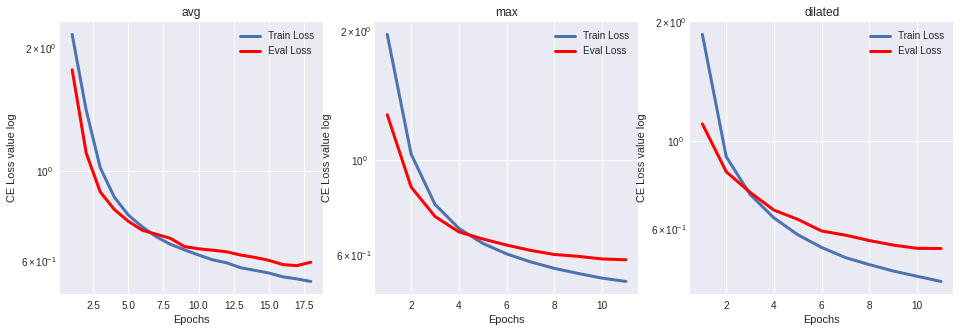

In [ ]:
plot_loss_list([cnn_avg_trainer, cnn_max_trainer, cnn_dilated_trainer], ['avg', 'max', 'dilated'])

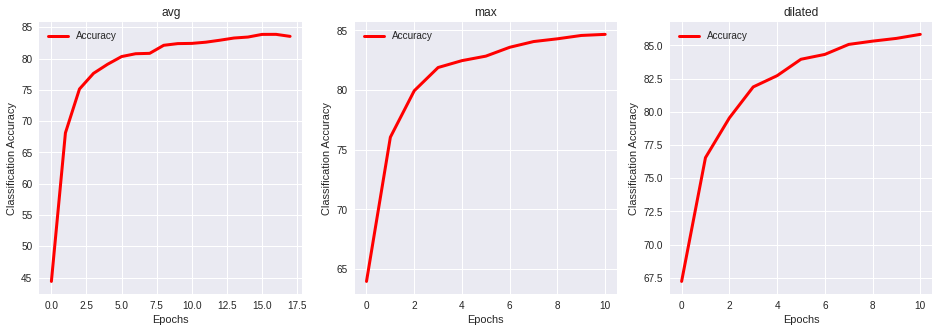

In [ ]:
plot_acc_list([cnn_avg_trainer, cnn_max_trainer, cnn_dilated_trainer], ['avg', 'max', 'dilated'])

### Comparing 2 models with dilated convolution as the downsampling operator: with and without dropout

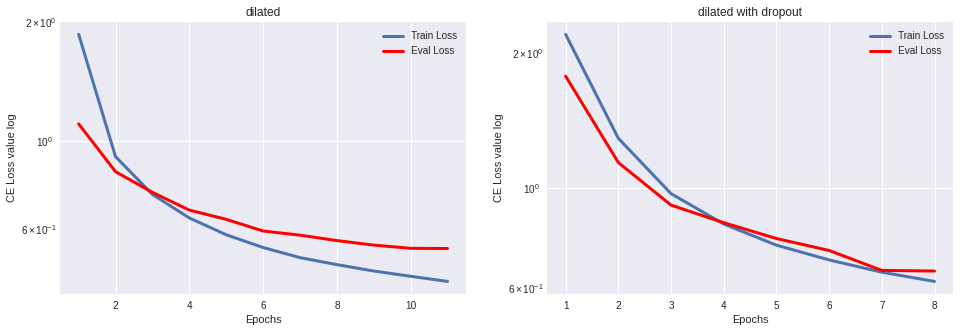

In [ ]:
plot_loss_list([cnn_dilated_trainer, cnn_dilated_dropout_trainer], ['dilated', 'dilated with dropout'])

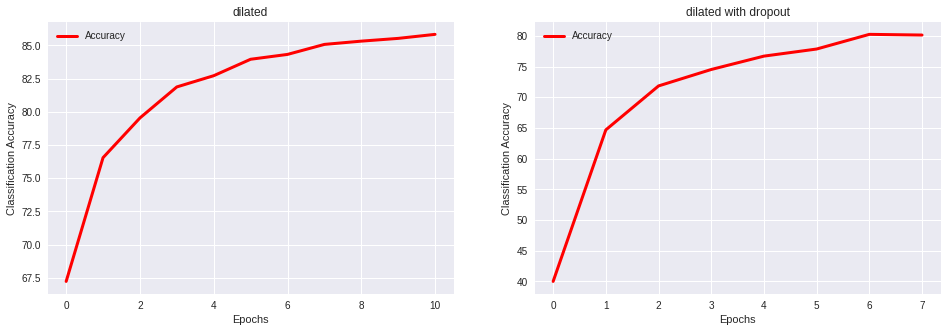

In [ ]:
plot_acc_list([cnn_dilated_trainer, cnn_dilated_dropout_trainer], ['dilated', 'dilated with dropout'])